In [1]:
import numpy as np
import os
import pandas as pd
import glob
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = 'data'
performance_path = os.path.join(data_path, 'performance', 'final_classifier_grid')
config_path = os.path.join(data_path, 'config', 'grid', 'final_classifier')
figure_path = os.path.join(data_path, 'figures')

In [3]:
def path_split(x):
    x = x.replace('/', ' ').split()
    return x

## Load the data

In [4]:
def load_group_map(label_path):
    return pd.concat(
        {key: pd.read_csv(os.path.join(label_path, '{}_map.csv'.format(key)))
          for key in ['age', 'gender', 'race_eth']}). \
        reset_index(1, drop = True). \
        rename_axis(index = 'sensitive_variable'). \
        rename(columns = {'category_id' : 'group', 'categories' : 'group_name'})  

def load_eval_data(performance_path):
    files_eval = glob.glob(os.path.join(performance_path, '**', '*_eval.csv'), recursive=True)
    df_eval = pd.concat({(file, path_split(file)[-4], path_split(file)[-3], path_split(file)[-2]): 
                        pd.read_csv(file) for file in files_eval})
    df_eval = df_eval.rename_axis(index = ['file_path', 'outcome', 'sensitive_variable', 'experiment_id', 'index'])
    df_eval = df_eval.reset_index([0, 1, 2, 3])
    df_eval['experiment_id'] = df_eval['experiment_id'].astype('int')
    return df_eval

def load_config_data(config_path):
    files_config = glob.glob(os.path.join(config_path, '**', 'config.csv'), recursive=True)
    df_config = pd.concat({(file, path_split(file)[-3], path_split(file)[-2]): 
                pd.read_csv(file) for file in files_config})
    df_config = df_config.rename_axis(index = ['file_path', 'outcome', 'sensitive_variable', 'index'])
    df_config = df_config.rename(columns = {'id' : 'experiment_id'})
    df_config = df_config.reset_index([0, 1, 2])
    return df_config

def load_preds_data(performance_path, group_map):
    files_preds = glob.glob(os.path.join(performance_path, '**', '*_cf_df.csv'), recursive=True)
    df_preds = pd.concat({(file, path_split(file)[-4], path_split(file)[-3], path_split(file)[-2]): 
                        pd.read_csv(file) for file in files_preds})
    df_preds = df_preds.rename_axis(index = ['file_path', 'outcome', 'sensitive_variable', 'experiment_id', 'index'])
    df_preds = df_preds.reset_index([0, 1, 2, 3])
    df_preds['experiment_id'] = df_preds['experiment_id'].astype('int')
    df_preds = pd.merge(df_preds, group_map.reset_index(), how = 'left')
    df_preds = pd.merge(df_preds, group_map.reset_index(). \
                          rename(columns = {'group' : 'group_cf', 'group_name' : 'group_cf_name'}), how = 'left')
    return df_preds

def load_baseline_data(performance_path_baseline):
    files_baseline = glob.glob(os.path.join(performance_path_baseline, '**', '*_eval.csv'), recursive=True)
    df_baseline = pd.concat({(file, path_split(file)[-3], path_split(file)[-2]): 
                            pd.read_csv(file) for file in files_baseline})
    df_baseline = df_baseline.rename_axis(index = ['file_path', 'outcome', 'experiment_id', 'index'])
    df_baseline = df_baseline.reset_index([0, 2, 3], drop = True)
    df_baseline = df_baseline.loc[df_baseline.phase == 'test']
    df_baseline = df_baseline.drop(columns = ['epoch', 'phase'])
    df_baseline = df_baseline.rename(columns = {'performance' : 'baseline'})
    return df_baseline

In [5]:
## Load group maps
label_path = os.path.join(data_path, 'labels')
os.listdir(label_path)
group_map_df = load_group_map(label_path)

In [6]:
## Load eval data
df_eval = load_eval_data(performance_path)

In [7]:
## Load config data
df_config = load_config_data(config_path)

In [8]:
## Load preds data
df_preds = load_preds_data(performance_path, group_map = group_map_df)

In [9]:
## Select the hyperparameters based on minimum CLP

df = pd.merge(df_eval, df_config, how = 'inner', on = ['experiment_id', 'outcome', 'sensitive_variable'])

df_config_temp = (
    df
        .query('(metric == "clp") & (phase == "val")')
        .groupby(['outcome', 'sensitive_variable', 'lambda_clp'])
        [['performance']]
        .agg('min')
        .reset_index()
        .merge(df, how = 'inner')
        .loc[:, ['outcome', 'sensitive_variable', 'lambda_clp', 'experiment_id']]
)

In [10]:
# df_preds_temp = df_preds.loc[
#     (df_preds.sensitive_variable == 'race_eth') & 
#     (df_preds.outcome == 'mortality') & 
#     (df_preds.phase == 'test')
#]

In [16]:
# ## Selected hyperparameters
# df_config_temp = df_config.loc[
#                                 (df_config.cf_gradients == False) &
#                                (df_config.lambda_final_classifier_cf == 1.0) &
#                                (df_config.lr_final_classifier == 1e-3) & 
#                                (df_config.weighted == False)
#                               ]

In [11]:
# df_selected = pd.merge(df_preds_temp, 
#                        df_config_temp, 
#                        how = 'inner', 
#                        on = ['experiment_id', 'outcome', 'sensitive_variable'])
# df_selected = df_selected.loc[(df_selected.y == df_selected.y_cf) & (df_selected.y == 0)]

In [23]:
# temp = df_selected.groupby(['phase', 'y', 'y_cf', 'group_name', 'group_cf_name', 'lambda_clp'])[['pred_diff']]. \
#         agg(lambda x: np.mean(x)). \
#         reset_index()
# temp['color'] = np.where(temp['pred_diff'] >= 0.0, 'blue', 'red')

# # # temp. \
# # #     groupby('lambda_clp'). \
# # #     apply(lambda x: x.pivot('group_name', 'group_cf_name', 'pred_diff'))

In [26]:
col_order_dict = {'race_eth' : ['Asian', 'Black', 'Hispanic', 'Other', 'Unknown', 'White'],
                 'gender' : ['Female', 'Male'],
                  'age' : group_map_df.loc[group_map_df.index.get_level_values('sensitive_variable') == 'age'].group_name.array
                 }

In [185]:
style_dict = {
    'race_eth' : {'row' : {'x' : 0.45, 
                           'y': 0.05, 
                           's' : r'Strength of $\lambda_{CLP}$',
                           'rotation' : 'horizontal',
                           'fontsize' : 'xx-large'
                          },
                  'col' : {'x' : 0.06, 
                           'y': 0.75, 
                           's' : 'Mean paired difference in predicted probability',
                           'rotation' : 'vertical',
                           'fontsize' : 'xx-large'
                          },
                  'adjust' : {
                      'top' : 0.9, 'left' : 0.1, 'bottom' : 0.1
                  }
                 },
    'gender' : {'row' : {'x' : 0.4, 
                         'y' : 0.05, 
                         's' : r'Strength of $\lambda_{CLP}$', 
                         'rotation' : 'horizontal', 
                         'fontsize':'large'
                        },
                'col' : {'x' : 0.05, 
                         'y' : 0.75, 
                         's' : 'Mean paired difference \n in predicted probability', 
                         'rotation' : 'vertical', 
                         'fontsize':'large'
                        },
                'adjust' : {
                      'top' : 0.9, 'left' : 0.2, 'bottom' : 0.2
                  }
                 },
    'age' : {'row' : {'x' : 0.45, 
                      'y': 0.05, 
                      's' : r'Strength of $\lambda_{CLP}$',
                      'rotation' : 'horizontal',
                      'fontsize' : 'large'
                     },
             'col' : {'x' : 0.05, 
                      'y': 0.74, 
                      's' : 'Mean paired difference in predicted probability',
                      'rotation' : 'vertical',
                      'fontsize' : 'large'
                     },
             'adjust' : {
                      'top' : 0.9, 'left' : 0.1, 'bottom' : 0.1
                  }
            }
}


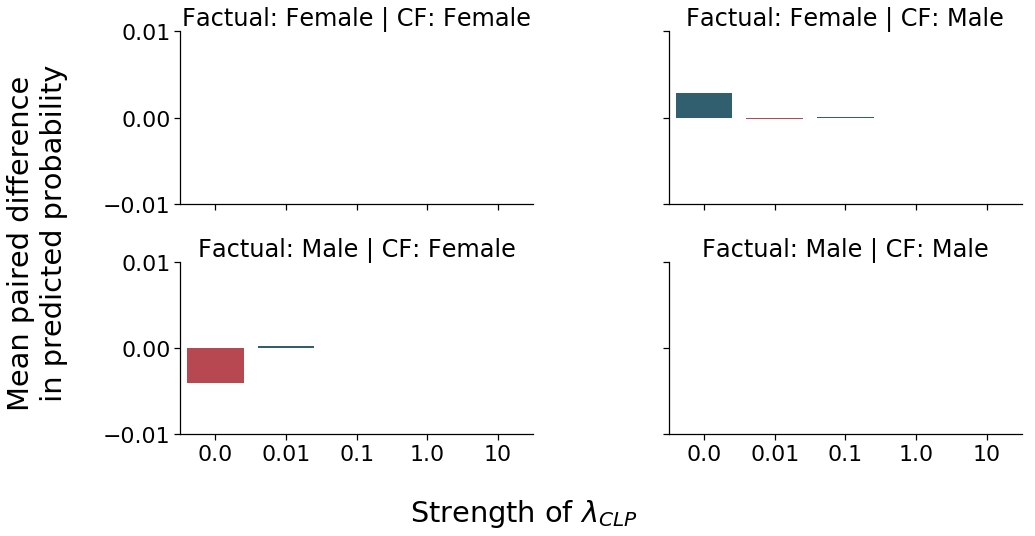

In [159]:
# ## A testing cell
# sensitive_variable = 'gender'
# outcome = 'mortality'
# y = 0
# y_cf = 0

# df_preds_temp = df_preds.loc[
#     (df_preds.sensitive_variable == sensitive_variable) & 
#     (df_preds.outcome == outcome) & 
#     (df_preds.phase == 'test')]

# df_selected = pd.merge(df_preds_temp, 
#                        df_config_temp, 
#                        how = 'inner', 
#                        on = ['experiment_id', 'outcome', 'sensitive_variable'])
# df_selected = df_selected.query('(y == @y) & (y_cf == @y_cf)')
# temp = df_selected.groupby(['phase', 'y', 'y_cf', 'group_name', 'group_cf_name', 'lambda_clp'])[['pred_diff']]. \
#         agg(lambda x: np.mean(x)). \
#         reset_index()
# temp['color'] = np.where(temp['pred_diff'] >= 0.0, 'blue', 'red')

# figure_path = os.path.join(data_path, 'figures')
# with sns.plotting_context('notebook', font_scale=2):
#     g = sns.FacetGrid(temp,
#                       hue = 'color',
#                       row = "group_name", 
#                       col = "group_cf_name",
#                       row_order = col_order_dict[sensitive_variable],
#                       col_order = col_order_dict[sensitive_variable],
#                       hue_order = ['blue', 'red'],
#                       palette = {'blue' : '#27647B', 'red' : '#CA3542'},
#                       ylim = [-0.01, 0.01],
#                       height = 4,
#                       aspect = 2
#                      )
#     g.map(sns.barplot, 'lambda_clp', 'pred_diff', 
#           order = [0.0, 0.01, 0.1, 1.0, 10]
#          )
# #     plt.subplots_adjust(top = 0.9, left = 0.2, bottom = 0.2)
#     plt.subplots_adjust(**style_dict[sensitive_variable]['adjust'])
#     g.fig.text(**style_dict[sensitive_variable]['row'])
#     g.fig.text(**style_dict[sensitive_variable]['col'])
#     for ax in g.axes.flat:
#         ax.set_yticks([-0.01, 0.0, 0.01])
#     g.set_xlabels('')
#     g.set_ylabels('')
#     g.set_titles(row_template = 'Factual: {row_name}', col_template = 'CF: {col_name}')
#     g.savefig(os.path.join(figure_path, 'test.png'), dpi = 90)

In [186]:
figure_path = os.path.join(data_path, 'figures', 'bar_plot_pred_diff')
os.makedirs(figure_path, exist_ok = True)

for sensitive_variable in ['race_eth', 'age', 'gender']:
    for outcome in ['mortality', 'los']:
        for y in [0, 1]:
            for y_cf in [0, 1]:
                print(sensitive_variable, outcome, y, y_cf)
                df_preds_temp = df_preds.loc[(df_preds.sensitive_variable == sensitive_variable) & 
                                    (df_preds.outcome == outcome) & 
                                    (df_preds.phase == 'test')
                                   ]
                df_selected = pd.merge(df_preds_temp, df_config_temp, 
                                       how = 'inner', on = ['experiment_id', 'outcome', 'sensitive_variable'])
                df_selected = df_selected.query('(y == @y) & (y_cf == @y_cf)')
                temp = df_selected.groupby(['phase', 
                                            'y', 'y_cf', 
                                            'group_name', 'group_cf_name', 
                                            'lambda_clp'])[['pred_diff']]. \
                    agg(lambda x: np.mean(x)). \
                    reset_index()
                temp['color'] = np.where(temp['pred_diff'] >= 0.0, 'blue', 'red')
                with sns.plotting_context('notebook', font_scale=2):
                    g = sns.FacetGrid(temp,
                                      hue = 'color',
                                      row = "group_name", 
                                      col = "group_cf_name", 
                                      row_order = col_order_dict[sensitive_variable],
                                      col_order = col_order_dict[sensitive_variable],
                                      palette = {'blue' : '#27647B', 'red' : '#CA3542'},
                                      height = 4,
                                      aspect = 2
                                     )

                    g.map(sns.barplot, 'lambda_clp', 'pred_diff', order = [0.0, 0.01, 0.1, 1.0, 10])
                    plt.subplots_adjust(**style_dict[sensitive_variable]['adjust'])
                    
                    g.fig.text(**style_dict[sensitive_variable]['row'])
                    g.fig.text(**style_dict[sensitive_variable]['col'])
                
                    g.set_xlabels('')
                    g.set_ylabels('')
                    g.set_titles(row_template = 'Factual: {row_name}', col_template = 'CF: {col_name}')
                    the_path = os.path.join(figure_path, outcome, sensitive_variable)
                    os.makedirs(the_path, exist_ok = True)
                    g.savefig(os.path.join(the_path, '{}_{}.png'.format(y, y_cf)), dpi = 90)
                    plt.close()

race_eth mortality 0 0
race_eth mortality 0 1
race_eth mortality 1 0
race_eth mortality 1 1
race_eth los 0 0
race_eth los 0 1
race_eth los 1 0
race_eth los 1 1
age mortality 0 0
age mortality 0 1
age mortality 1 0
age mortality 1 1
age los 0 0
age los 0 1
age los 1 0
age los 1 1
gender mortality 0 0
gender mortality 0 1
gender mortality 1 0
gender mortality 1 1
gender los 0 0
gender los 0 1
gender los 1 0
gender los 1 1


## Make tables

In [243]:
metric_names = pd.DataFrame({'auc' : 'AUC-ROC',
                'auprc' : 'AUC-PRC',
                'brier' : 'Brier',
                'clp' : 'CLP'
               }, index = [0]).transpose().reset_index()
metric_names.columns = ['metric', 'Metric']
display(metric_names)

,metric,Metric
0,auc,AUC-ROC
1,auprc,AUC-PRC
2,brier,Brier
3,clp,CLP


In [244]:
df_summary = pd.merge(df_eval, 
                      df_config_temp, 
                      how = 'inner', 
                      on = ['experiment_id', 'outcome', 'sensitive_variable'])

df_summary = df_summary.merge(metric_names)
temp = (
    df_summary
        .query('phase == "test"')
        .groupby(['outcome', 'sensitive_variable', 'Metric', 'lambda_clp'])
        [['performance']]
        .agg(lambda x: x)
        .reset_index()
        .groupby(['outcome', 'sensitive_variable'])
        .apply(lambda x: x.pivot('Metric', 'lambda_clp', 'performance'))
        .query('Metric in ["AUC-ROC", "AUC-PRC", "Brier", "CLP"]')
)

display(temp)

lambda_clp                               0.00      0.01      0.10      1.00   \
outcome   sensitive_variable Metric                                            
los       age                AUC-PRC  0.542418  0.554723  0.555452  0.555367   
                             AUC-ROC  0.822424  0.836185  0.835626  0.836262   
                             Brier    0.125203  0.121748  0.121515  0.119372   
                             CLP      0.107155  0.039837  0.010409  0.000270   
          gender             AUC-PRC  0.563061  0.566558  0.568298  0.560430   
                             AUC-ROC  0.839957  0.840824  0.842060  0.838586   
                             Brier    0.118437  0.119400  0.118399  0.117685   
                             CLP      0.099949  0.033488  0.004264  0.000050   
          race_eth           AUC-PRC  0.559762  0.563765  0.563436  0.562708   
                             AUC-ROC  0.843112  0.843921  0.843763  0.844623   
                             Brier    0.119643  0.116571  0.117125  0.117487   
                             CLP      0.023666  0.010632  0.001106  0.000111   
mortality age                AUC-PRC  0.203292  0.187425  0.183374  0.201992   
                             AUC-ROC  0.869418  0.829379  0.823229  0.821852   
                             Brier    0.023952  0.023977  0.022041  0.022532   
                             CLP      0.223237  0.019078  0.005496  0.000237   
          gender             AUC-PRC  0.218202  0.208369  0.208339  0.202895   
                             AUC-ROC  0.878894  0.868003  0.870533  0.871808   
                             Brier    0.020718  0.020843  0.020739  0.020863   
                             CLP      0.036343  0.000355  0.000071  0.000003   
          race_eth           AUC-PRC  0.193307  0.191886  0.185525  0.197484   
                             AUC-ROC  0.859210  0.856032  0.820425  0.800105   
                             Brier    0.025373  0.025014  0.025295  0.022810   
                             CLP      0.092928  0.018929  0.004559  0.000355   

lambda_clp                                   10.00  
outcome   sensitive_variable Metric                 
los       age                AUC-PRC  5.636001e-01  
                             AUC-ROC  8.350229e-01  
                             Brier    1.210118e-01  
                             CLP      1.994523e-05  
          gender             AUC-PRC  5.578248e-01  
                             AUC-ROC  8.354326e-01  
                             Brier    1.339475e-01  
                             CLP      9.821019e-06  
          race_eth           AUC-PRC  5.630784e-01  
                             AUC-ROC  8.432372e-01  
                             Brier    1.196575e-01  
                             CLP      2.436767e-05  
mortality age                AUC-PRC  1.620337e-01  
                             AUC-ROC  8.096390e-01  
                             Brier    2.433791e-02  
                             CLP      8.731168e-07  
          gender             AUC-PRC  7.717635e-02  
                             AUC-ROC  7.598295e-01  
                             Brier    2.414012e-02  
                             CLP      1.035371e-07  
          race_eth           AUC-PRC  1.940667e-01  
                             AUC-ROC  8.002127e-01  
                             Brier    2.412388e-02  
                             CLP      1.217667e-06

In [245]:
performance_path_baseline = os.path.join(data_path, 'performance', 'baseline_default')
df_baseline = load_baseline_data(performance_path_baseline)

df_baseline = df_baseline.reset_index().merge(metric_names, how = 'inner')
display(df_baseline)

df = pd.merge(temp.reset_index([0, 1, 2]), df_baseline.reset_index(), how = 'left')
df = df.set_index(['outcome', 'sensitive_variable', 'Metric'])
df = df[['baseline', 0.0, 0.01, 0.1, 1.0, 10.0]]
display(df)

,outcome,metric,baseline,Metric
0,los,auc,0.850835,AUC-ROC
1,mortality,auc,0.892904,AUC-ROC
2,los,auprc,0.581952,AUC-PRC
3,mortality,auprc,0.267086,AUC-PRC
4,los,brier,0.115485,Brier
5,mortality,brier,0.020567,Brier


baseline       0.0      0.01       0.1  \
outcome   sensitive_variable Metric                                            
los       age                AUC-PRC  0.581952  0.542418  0.554723  0.555452   
                             AUC-ROC  0.850835  0.822424  0.836185  0.835626   
                             Brier    0.115485  0.125203  0.121748  0.121515   
                             CLP           NaN  0.107155  0.039837  0.010409   
          gender             AUC-PRC  0.581952  0.563061  0.566558  0.568298   
                             AUC-ROC  0.850835  0.839957  0.840824  0.842060   
                             Brier    0.115485  0.118437  0.119400  0.118399   
                             CLP           NaN  0.099949  0.033488  0.004264   
          race_eth           AUC-PRC  0.581952  0.559762  0.563765  0.563436   
                             AUC-ROC  0.850835  0.843112  0.843921  0.843763   
                             Brier    0.115485  0.119643  0.116571  0.117125   
                             CLP           NaN  0.023666  0.010632  0.001106   
mortality age                AUC-PRC  0.267086  0.203292  0.187425  0.183374   
                             AUC-ROC  0.892904  0.869418  0.829379  0.823229   
                             Brier    0.020567  0.023952  0.023977  0.022041   
                             CLP           NaN  0.223237  0.019078  0.005496   
          gender             AUC-PRC  0.267086  0.218202  0.208369  0.208339   
                             AUC-ROC  0.892904  0.878894  0.868003  0.870533   
                             Brier    0.020567  0.020718  0.020843  0.020739   
                             CLP           NaN  0.036343  0.000355  0.000071   
          race_eth           AUC-PRC  0.267086  0.193307  0.191886  0.185525   
                             AUC-ROC  0.892904  0.859210  0.856032  0.820425   
                             Brier    0.020567  0.025373  0.025014  0.025295   
                             CLP           NaN  0.092928  0.018929  0.004559   

                                           1.0          10.0  
outcome   sensitive_variable Metric                           
los       age                AUC-PRC  0.555367  5.636001e-01  
                             AUC-ROC  0.836262  8.350229e-01  
                             Brier    0.119372  1.210118e-01  
                             CLP      0.000270  1.994523e-05  
          gender             AUC-PRC  0.560430  5.578248e-01  
                             AUC-ROC  0.838586  8.354326e-01  
                             Brier    0.117685  1.339475e-01  
                             CLP      0.000050  9.821019e-06  
          race_eth           AUC-PRC  0.562708  5.630784e-01  
                             AUC-ROC  0.844623  8.432372e-01  
                             Brier    0.117487  1.196575e-01  
                             CLP      0.000111  2.436767e-05  
mortality age                AUC-PRC  0.201992  1.620337e-01  
                             AUC-ROC  0.821852  8.096390e-01  
                             Brier    0.022532  2.433791e-02  
                             CLP      0.000237  8.731168e-07  
          gender             AUC-PRC  0.202895  7.717635e-02  
                             AUC-ROC  0.871808  7.598295e-01  
                             Brier    0.020863  2.414012e-02  
                             CLP      0.000003  1.035371e-07  
          race_eth           AUC-PRC  0.197484  1.940667e-01  
                             AUC-ROC  0.800105  8.002127e-01  
                             Brier    0.022810  2.412388e-02  
                             CLP      0.000355  1.217667e-06

In [259]:
table_path = './latex_tables'
table_path_temp = os.path.join(table_path, 'group_performance')
os.makedirs(table_path_temp, exist_ok = True)

## Print with all groups
with open(os.path.join(table_path_temp, 'all_groups.txt'), 'w') as fp:
    df.to_latex(fp, float_format = '%.3g')

## Save for each outcome-group pair separately
for group_id, the_df in df.groupby(['outcome', 'sensitive_variable']):
    the_df = the_df.reset_index([0, 1], drop = True)
    the_df = the_df.transpose()
    display(the_df)
    with open(os.path.join(table_path_temp, '{}.txt'.format('_'.join(group_id))), 'w') as fp:
        the_df.to_latex(fp, float_format = '%.3g', index = False)
        
## Save for each outcome-group pair separately
for group_id, the_df in df.groupby(['sensitive_variable']):
    print(group_id)
    the_df = the_df.reset_index(1, drop = True)
    the_df = the_df.transpose()
    display(the_df)
    with open(os.path.join(table_path_temp, '{}.txt'.format(group_id)), 'w') as fp:
        the_df.to_latex(fp, float_format = '%.3g', multicolumn_format='c', index_names = False)

Metric,AUC-PRC,AUC-ROC,Brier,CLP
baseline,0.581952,0.850835,0.115485,NaN
0.0,0.542418,0.822424,0.125203,0.107155
0.01,0.554723,0.836185,0.121748,0.039837
0.1,0.555452,0.835626,0.121515,0.010409
1.0,0.555367,0.836262,0.119372,0.000270
10.0,0.563600,0.835023,0.121012,0.000020


Metric,AUC-PRC,AUC-ROC,Brier,CLP
baseline,0.581952,0.850835,0.115485,NaN
0.0,0.563061,0.839957,0.118437,0.099949
0.01,0.566558,0.840824,0.119400,0.033488
0.1,0.568298,0.842060,0.118399,0.004264
1.0,0.560430,0.838586,0.117685,0.000050
10.0,0.557825,0.835433,0.133947,0.000010


Metric,AUC-PRC,AUC-ROC,Brier,CLP
baseline,0.581952,0.850835,0.115485,NaN
0.0,0.559762,0.843112,0.119643,0.023666
0.01,0.563765,0.843921,0.116571,0.010632
0.1,0.563436,0.843763,0.117125,0.001106
1.0,0.562708,0.844623,0.117487,0.000111
10.0,0.563078,0.843237,0.119658,0.000024


Metric,AUC-PRC,AUC-ROC,Brier,CLP
baseline,0.267086,0.892904,0.020567,NaN
0.0,0.203292,0.869418,0.023952,2.232374e-01
0.01,0.187425,0.829379,0.023977,1.907837e-02
0.1,0.183374,0.823229,0.022041,5.496449e-03
1.0,0.201992,0.821852,0.022532,2.370772e-04
10.0,0.162034,0.809639,0.024338,8.731168e-07


Metric,AUC-PRC,AUC-ROC,Brier,CLP
baseline,0.267086,0.892904,0.020567,NaN
0.0,0.218202,0.878894,0.020718,3.634343e-02
0.01,0.208369,0.868003,0.020843,3.552984e-04
0.1,0.208339,0.870533,0.020739,7.123840e-05
1.0,0.202895,0.871808,0.020863,3.366247e-06
10.0,0.077176,0.759830,0.024140,1.035371e-07


Metric,AUC-PRC,AUC-ROC,Brier,CLP
baseline,0.267086,0.892904,0.020567,NaN
0.0,0.193307,0.859210,0.025373,0.092928
0.01,0.191886,0.856032,0.025014,0.018929
0.1,0.185525,0.820425,0.025295,0.004559
1.0,0.197484,0.800105,0.022810,0.000355
10.0,0.194067,0.800213,0.024124,0.000001


age


outcome        los                               mortality            \
Metric     AUC-PRC   AUC-ROC     Brier       CLP   AUC-PRC   AUC-ROC   
baseline  0.581952  0.850835  0.115485       NaN  0.267086  0.892904   
0.0       0.542418  0.822424  0.125203  0.107155  0.203292  0.869418   
0.01      0.554723  0.836185  0.121748  0.039837  0.187425  0.829379   
0.1       0.555452  0.835626  0.121515  0.010409  0.183374  0.823229   
1.0       0.555367  0.836262  0.119372  0.000270  0.201992  0.821852   
10.0      0.563600  0.835023  0.121012  0.000020  0.162034  0.809639   

outcome                           
Metric       Brier           CLP  
baseline  0.020567           NaN  
0.0       0.023952  2.232374e-01  
0.01      0.023977  1.907837e-02  
0.1       0.022041  5.496449e-03  
1.0       0.022532  2.370772e-04  
10.0      0.024338  8.731168e-07

gender


outcome        los                               mortality            \
Metric     AUC-PRC   AUC-ROC     Brier       CLP   AUC-PRC   AUC-ROC   
baseline  0.581952  0.850835  0.115485       NaN  0.267086  0.892904   
0.0       0.563061  0.839957  0.118437  0.099949  0.218202  0.878894   
0.01      0.566558  0.840824  0.119400  0.033488  0.208369  0.868003   
0.1       0.568298  0.842060  0.118399  0.004264  0.208339  0.870533   
1.0       0.560430  0.838586  0.117685  0.000050  0.202895  0.871808   
10.0      0.557825  0.835433  0.133947  0.000010  0.077176  0.759830   

outcome                           
Metric       Brier           CLP  
baseline  0.020567           NaN  
0.0       0.020718  3.634343e-02  
0.01      0.020843  3.552984e-04  
0.1       0.020739  7.123840e-05  
1.0       0.020863  3.366247e-06  
10.0      0.024140  1.035371e-07

race_eth


outcome        los                               mortality            \
Metric     AUC-PRC   AUC-ROC     Brier       CLP   AUC-PRC   AUC-ROC   
baseline  0.581952  0.850835  0.115485       NaN  0.267086  0.892904   
0.0       0.559762  0.843112  0.119643  0.023666  0.193307  0.859210   
0.01      0.563765  0.843921  0.116571  0.010632  0.191886  0.856032   
0.1       0.563436  0.843763  0.117125  0.001106  0.185525  0.820425   
1.0       0.562708  0.844623  0.117487  0.000111  0.197484  0.800105   
10.0      0.563078  0.843237  0.119658  0.000024  0.194067  0.800213   

outcome                       
Metric       Brier       CLP  
baseline  0.020567       NaN  
0.0       0.025373  0.092928  
0.01      0.025014  0.018929  
0.1       0.025295  0.004559  
1.0       0.022810  0.000355  
10.0      0.024124  0.000001

### Tables by group

In [260]:
def load_data_by_group(performance_path):
    files_by_group = glob.glob(os.path.join(performance_path, '**', '*_by_group.csv'), recursive=True)
    df_by_group = pd.concat({(file, path_split(file)[-4], path_split(file)[-3], path_split(file)[-2]): 
                            pd.read_csv(file) for file in files_by_group})
    df_by_group = df_by_group.drop(columns = 'sensitive_variable')
    df_by_group = df_by_group.rename_axis(index = ['file_path', 'outcome', 'sensitive_variable', 'experiment_id', 'index'])
    df_by_group = df_by_group.reset_index([0, 1, 2, 3])
    df_by_group['experiment_id'] = df_by_group['experiment_id'].astype(int)
    
    return df_by_group

def load_data_baseline_by_group(performance_path_baseline):
    files_baseline = glob.glob(os.path.join(performance_path_baseline, '**', '*_by_group.csv'), recursive=True)
    df_baseline = pd.concat({(file, path_split(file)[-3], path_split(file)[-2]): 
                            pd.read_csv(file) for file in files_baseline})
    df_baseline = df_baseline.rename_axis(index = ['file_path', 'outcome', 'experiment_id', 'index'])
    df_baseline = df_baseline.reset_index([0, 1, 2, 3])
    df_baseline = df_baseline.loc[df_baseline.phase == 'test']
    df_baseline = df_baseline.drop(columns = ['epoch', 'phase'])
    df_baseline = df_baseline.rename(columns = {'performance' : 'baseline'})
    df_baseline = df_baseline.drop(columns = ['experiment_id', 'file_path', 'index'])
    return df_baseline
    

In [261]:
df_by_group = load_data_by_group(performance_path)

In [262]:
df_summary = pd.merge(df_by_group, df_config_temp, 
                      how = 'inner', 
                      on = ['experiment_id', 'outcome', 'sensitive_variable'])

df_summary = df_summary.loc[df_summary.phase == 'test']
df_summary = df_summary.merge(metric_names)

temp = df_summary. \
            groupby(['outcome', 'sensitive_variable', 'Metric', 'group', 'lambda_clp'])[['performance']]. \
            agg(lambda x: x). \
            reset_index()

temp = temp. \
        groupby(['outcome', 'sensitive_variable', 'group']). \
        apply(lambda x: x.pivot('Metric', 'lambda_clp', 'performance'))

temp = temp[temp.index.get_level_values('Metric').isin(['AUC-ROC', 'AUC-PRC', 'Brier', 'CLP'])]

In [263]:
## Load the baseline data - by group
performance_path_baseline = os.path.join(data_path, 'performance', 'baseline_default')
df_baseline = load_data_baseline_by_group(performance_path_baseline)
display(df_baseline.head())

,outcome,sensitive_variable,group,metric,baseline
4,los,age,0,auc,0.885375
5,los,age,0,auprc,0.607936
6,los,age,0,brier,0.098003
7,los,age,0,loss,0.345627
12,los,age,1,auc,0.881584


In [264]:
df_baseline = df_baseline.merge(metric_names)

In [265]:
temp = pd.merge(temp.reset_index(), df_baseline).set_index(['outcome', 'sensitive_variable', 'group', 'Metric'])

In [266]:
by_group_df = pd.merge(temp.reset_index(), group_map_df.reset_index(), how = 'left'). \
    set_index(['outcome', 'sensitive_variable', 'group_name', 'Metric']). \
    drop(columns = 'group')
by_group_df = by_group_df[['baseline', 0.0, 0.01, 0.1, 1.0, 10.0]]

In [267]:
display(by_group_df.head())

baseline       0.0      0.01  \
outcome sensitive_variable group_name Metric                                  
los     age                [18, 30)   AUC-PRC  0.607936  0.548342  0.581137   
                                      AUC-ROC  0.885375  0.840240  0.867757   
                                      Brier    0.098003  0.110305  0.106234   
                           [30, 45)   AUC-PRC  0.544652  0.515373  0.531752   
                                      AUC-ROC  0.881584  0.851886  0.868552   

                                                    0.1       1.0      10.0  
outcome sensitive_variable group_name Metric                                 
los     age                [18, 30)   AUC-PRC  0.596941  0.611417  0.597258  
                                      AUC-ROC  0.869070  0.874582  0.870493  
                                      Brier    0.103867  0.099192  0.103499  
                           [30, 45)   AUC-PRC  0.530805  0.549244  0.545545  
                                      AUC-ROC  0.864105  0.870805  0.867118

In [268]:
?pd.DataFrame.to_latex

In [269]:
by_group_df

baseline       0.0      0.01  \
outcome   sensitive_variable group_name Metric                                  
los       age                [18, 30)   AUC-PRC  0.607936  0.548342  0.581137   
                                        AUC-ROC  0.885375  0.840240  0.867757   
                                        Brier    0.098003  0.110305  0.106234   
                             [30, 45)   AUC-PRC  0.544652  0.515373  0.531752   
                                        AUC-ROC  0.881584  0.851886  0.868552   
                                        Brier    0.086962  0.092547  0.094147   
                             [45, 65)   AUC-PRC  0.606433  0.554129  0.561839   
                                        AUC-ROC  0.848664  0.816277  0.833734   
                                        Brier    0.123383  0.134521  0.132939   
                             [65, 89)   AUC-PRC  0.563892  0.536647  0.525150   
                                        AUC-ROC  0.816585  0.789815  0.802909   
                                        Brier    0.131354  0.141836  0.139826   
          gender             Female     AUC-PRC  0.563599  0.528591  0.543710   
                                        AUC-ROC  0.864030  0.853091  0.854075   
                                        Brier    0.099254  0.102370  0.103991   
                             Male       AUC-PRC  0.597364  0.587040  0.590001   
                                        AUC-ROC  0.828751  0.814506  0.818263   
                                        Brier    0.136158  0.139959  0.141123   
          race_eth           Asian      AUC-PRC  0.605468  0.563113  0.554631   
                                        AUC-ROC  0.860419  0.853123  0.853054   
                                        Brier    0.106411  0.110498  0.109299   
                             Black      AUC-PRC  0.578670  0.548010  0.549796   
                                        AUC-ROC  0.838280  0.825441  0.820336   
                                        Brier    0.123782  0.134807  0.128935   
                             Hispanic   AUC-PRC  0.592101  0.557862  0.564632   
                                        AUC-ROC  0.861996  0.854845  0.856276   
                                        Brier    0.112616  0.117471  0.114791   
                             Other      AUC-PRC  0.548725  0.556890  0.556617   
                                        AUC-ROC  0.823867  0.827057  0.818976   
                                        Brier    0.122088  0.124467  0.120969   
...                                                   ...       ...       ...   
mortality age                [45, 65)   AUC-PRC  0.330344  0.199498  0.193873   
                                        AUC-ROC  0.905903  0.873914  0.880783   
                                        Brier    0.020805  0.026647  0.026054   
                             [65, 89)   AUC-PRC  0.258246  0.223129  0.218928   
                                        AUC-ROC  0.840287  0.813350  0.802044   
                                        Brier    0.035332  0.040359  0.040178   
          gender             Female     AUC-PRC  0.288583  0.235492  0.214555   
                                        AUC-ROC  0.924137  0.919746  0.906001   
                                        Brier    0.015953  0.015905  0.016095   
                             Male       AUC-PRC  0.254770  0.229854  0.216140   
                                        AUC-ROC  0.854455  0.849532  0.836053   
                                        Brier    0.026442  0.026674  0.026738   
          race_eth           Asian      AUC-PRC  0.238288  0.191541  0.178942   
                                        AUC-ROC  0.900243  0.848405  0.849074   
                                        Brier    0.021664  0.025516  0.025383   
                             Black      AUC-PRC  0.275382  0.152328  0.252885   
                                        AUC-ROC  0.898950  0.878390  0.862423   

In [271]:
?the_df.to_latex

In [275]:
table_path = './latex_tables'
table_path_temp = os.path.join(table_path, 'by_group_performance')
os.makedirs(table_path_temp, exist_ok = True)

## Print with all groups
with open(os.path.join(table_path_temp, 'all_groups.txt'), 'w') as fp:
    by_group_df.to_latex(fp, float_format = '%.3g')

# ## Save for each outcome-group pair separately
for group_id, the_df in by_group_df.groupby(['outcome', 'sensitive_variable']):
    print(group_id)
    display(the_df)
    print(the_df.columns)
    the_df = the_df.reset_index([0, 1], drop = True)
    print(the_df.columns)
    display(the_df)
    with open(os.path.join(table_path_temp, '{}.txt'.format('_'.join(group_id))), 'w') as fp:
        the_df.to_latex(fp, float_format = '%.3g', index = True)

('los', 'age')


baseline       0.0      0.01  \
outcome sensitive_variable group_name Metric                                  
los     age                [18, 30)   AUC-PRC  0.607936  0.548342  0.581137   
                                      AUC-ROC  0.885375  0.840240  0.867757   
                                      Brier    0.098003  0.110305  0.106234   
                           [30, 45)   AUC-PRC  0.544652  0.515373  0.531752   
                                      AUC-ROC  0.881584  0.851886  0.868552   
                                      Brier    0.086962  0.092547  0.094147   
                           [45, 65)   AUC-PRC  0.606433  0.554129  0.561839   
                                      AUC-ROC  0.848664  0.816277  0.833734   
                                      Brier    0.123383  0.134521  0.132939   
                           [65, 89)   AUC-PRC  0.563892  0.536647  0.525150   
                                      AUC-ROC  0.816585  0.789815  0.802909   
                                      Brier    0.131354  0.141836  0.139826   

                                                    0.1       1.0      10.0  
outcome sensitive_variable group_name Metric                                 
los     age                [18, 30)   AUC-PRC  0.596941  0.611417  0.597258  
                                      AUC-ROC  0.869070  0.874582  0.870493  
                                      Brier    0.103867  0.099192  0.103499  
                           [30, 45)   AUC-PRC  0.530805  0.549244  0.545545  
                                      AUC-ROC  0.864105  0.870805  0.867118  
                                      Brier    0.092262  0.088440  0.089518  
                           [45, 65)   AUC-PRC  0.574701  0.579447  0.590809  
                                      AUC-ROC  0.838364  0.838599  0.839369  
                                      Brier    0.128921  0.126402  0.129390  
                           [65, 89)   AUC-PRC  0.533592  0.532662  0.556371  
                                      AUC-ROC  0.802128  0.804407  0.806772  
                                      Brier    0.139225  0.136978  0.136462

Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')
Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')


baseline       0.0      0.01       0.1       1.0      10.0
group_name Metric                                                             
[18, 30)   AUC-PRC  0.607936  0.548342  0.581137  0.596941  0.611417  0.597258
           AUC-ROC  0.885375  0.840240  0.867757  0.869070  0.874582  0.870493
           Brier    0.098003  0.110305  0.106234  0.103867  0.099192  0.103499
[30, 45)   AUC-PRC  0.544652  0.515373  0.531752  0.530805  0.549244  0.545545
           AUC-ROC  0.881584  0.851886  0.868552  0.864105  0.870805  0.867118
           Brier    0.086962  0.092547  0.094147  0.092262  0.088440  0.089518
[45, 65)   AUC-PRC  0.606433  0.554129  0.561839  0.574701  0.579447  0.590809
           AUC-ROC  0.848664  0.816277  0.833734  0.838364  0.838599  0.839369
           Brier    0.123383  0.134521  0.132939  0.128921  0.126402  0.129390
[65, 89)   AUC-PRC  0.563892  0.536647  0.525150  0.533592  0.532662  0.556371
           AUC-ROC  0.816585  0.789815  0.802909  0.802128  0.804407  0.806772
           Brier    0.131354  0.141836  0.139826  0.139225  0.136978  0.136462

('los', 'gender')


baseline       0.0      0.01  \
outcome sensitive_variable group_name Metric                                  
los     gender             Female     AUC-PRC  0.563599  0.528591  0.543710   
                                      AUC-ROC  0.864030  0.853091  0.854075   
                                      Brier    0.099254  0.102370  0.103991   
                           Male       AUC-PRC  0.597364  0.587040  0.590001   
                                      AUC-ROC  0.828751  0.814506  0.818263   
                                      Brier    0.136158  0.139959  0.141123   

                                                    0.1       1.0      10.0  
outcome sensitive_variable group_name Metric                                 
los     gender             Female     AUC-PRC  0.538794  0.534201  0.541245  
                                      AUC-ROC  0.855601  0.854743  0.848148  
                                      Brier    0.103286  0.101500  0.116293  
                           Male       AUC-PRC  0.592749  0.583844  0.589319  
                                      AUC-ROC  0.817140  0.821997  0.819794  
                                      Brier    0.140422  0.137934  0.154963

Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')
Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')


baseline       0.0      0.01       0.1       1.0      10.0
group_name Metric                                                             
Female     AUC-PRC  0.563599  0.528591  0.543710  0.538794  0.534201  0.541245
           AUC-ROC  0.864030  0.853091  0.854075  0.855601  0.854743  0.848148
           Brier    0.099254  0.102370  0.103991  0.103286  0.101500  0.116293
Male       AUC-PRC  0.597364  0.587040  0.590001  0.592749  0.583844  0.589319
           AUC-ROC  0.828751  0.814506  0.818263  0.817140  0.821997  0.819794
           Brier    0.136158  0.139959  0.141123  0.140422  0.137934  0.154963

('los', 'race_eth')


baseline       0.0      0.01  \
outcome sensitive_variable group_name Metric                                  
los     race_eth           Asian      AUC-PRC  0.605468  0.563113  0.554631   
                                      AUC-ROC  0.860419  0.853123  0.853054   
                                      Brier    0.106411  0.110498  0.109299   
                           Black      AUC-PRC  0.578670  0.548010  0.549796   
                                      AUC-ROC  0.838280  0.825441  0.820336   
                                      Brier    0.123782  0.134807  0.128935   
                           Hispanic   AUC-PRC  0.592101  0.557862  0.564632   
                                      AUC-ROC  0.861996  0.854845  0.856276   
                                      Brier    0.112616  0.117471  0.114791   
                           Other      AUC-PRC  0.548725  0.556890  0.556617   
                                      AUC-ROC  0.823867  0.827057  0.818976   
                                      Brier    0.122088  0.124467  0.120969   
                           Unknown    AUC-PRC  0.675000  0.615826  0.615814   
                                      AUC-ROC  0.900451  0.890713  0.887695   
                                      Brier    0.103571  0.105698  0.103125   
                           White      AUC-PRC  0.575422  0.567816  0.564029   
                                      AUC-ROC  0.846567  0.839501  0.838918   
                                      Brier    0.117677  0.120089  0.118083   

                                                    0.1       1.0      10.0  
outcome sensitive_variable group_name Metric                                 
los     race_eth           Asian      AUC-PRC  0.560830  0.559938  0.562244  
                                      AUC-ROC  0.854476  0.849356  0.851311  
                                      Brier    0.109151  0.110160  0.112325  
                           Black      AUC-PRC  0.545459  0.562596  0.573300  
                                      AUC-ROC  0.825081  0.822742  0.823417  
                                      Brier    0.127556  0.126692  0.128811  
                           Hispanic   AUC-PRC  0.569585  0.564080  0.560333  
                                      AUC-ROC  0.861008  0.853251  0.853886  
                                      Brier    0.113621  0.117129  0.118487  
                           Other      AUC-PRC  0.562535  0.553499  0.561239  
                                      AUC-ROC  0.824402  0.819065  0.826554  
                                      Brier    0.120782  0.121796  0.124030  
                           Unknown    AUC-PRC  0.606265  0.613917  0.633243  
                                      AUC-ROC  0.892966  0.891317  0.887011  
                                      Brier    0.103041  0.104570  0.111240  
                           White      AUC-PRC  0.558674  0.562420  0.563269  
                                      AUC-ROC  0.837776  0.838132  0.837274  
                                      Brier    0.119543  0.119931  0.121290

Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')
Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')


baseline       0.0      0.01       0.1       1.0      10.0
group_name Metric                                                             
Asian      AUC-PRC  0.605468  0.563113  0.554631  0.560830  0.559938  0.562244
           AUC-ROC  0.860419  0.853123  0.853054  0.854476  0.849356  0.851311
           Brier    0.106411  0.110498  0.109299  0.109151  0.110160  0.112325
Black      AUC-PRC  0.578670  0.548010  0.549796  0.545459  0.562596  0.573300
           AUC-ROC  0.838280  0.825441  0.820336  0.825081  0.822742  0.823417
           Brier    0.123782  0.134807  0.128935  0.127556  0.126692  0.128811
Hispanic   AUC-PRC  0.592101  0.557862  0.564632  0.569585  0.564080  0.560333
           AUC-ROC  0.861996  0.854845  0.856276  0.861008  0.853251  0.853886
           Brier    0.112616  0.117471  0.114791  0.113621  0.117129  0.118487
Other      AUC-PRC  0.548725  0.556890  0.556617  0.562535  0.553499  0.561239
           AUC-ROC  0.823867  0.827057  0.818976  0.824402  0.819065  0.826554
           Brier    0.122088  0.124467  0.120969  0.120782  0.121796  0.124030
Unknown    AUC-PRC  0.675000  0.615826  0.615814  0.606265  0.613917  0.633243
           AUC-ROC  0.900451  0.890713  0.887695  0.892966  0.891317  0.887011
           Brier    0.103571  0.105698  0.103125  0.103041  0.104570  0.111240
White      AUC-PRC  0.575422  0.567816  0.564029  0.558674  0.562420  0.563269
           AUC-ROC  0.846567  0.839501  0.838918  0.837776  0.838132  0.837274
           Brier    0.117677  0.120089  0.118083  0.119543  0.119931  0.121290

('mortality', 'age')


baseline       0.0      0.01  \
outcome   sensitive_variable group_name Metric                                  
mortality age                [18, 30)   AUC-PRC  0.050696  0.058929  0.051961   
                                        AUC-ROC  0.830328  0.806778  0.641579   
                                        Brier    0.005647  0.006837  0.006975   
                             [30, 45)   AUC-PRC  0.333373  0.241104  0.207685   
                                        AUC-ROC  0.970001  0.907010  0.943085   
                                        Brier    0.004832  0.005019  0.005462   
                             [45, 65)   AUC-PRC  0.330344  0.199498  0.193873   
                                        AUC-ROC  0.905903  0.873914  0.880783   
                                        Brier    0.020805  0.026647  0.026054   
                             [65, 89)   AUC-PRC  0.258246  0.223129  0.218928   
                                        AUC-ROC  0.840287  0.813350  0.802044   
                                        Brier    0.035332  0.040359  0.040178   

                                                      0.1       1.0      10.0  
outcome   sensitive_variable group_name Metric                                 
mortality age                [18, 30)   AUC-PRC  0.058201  0.051561  0.022969  
                                        AUC-ROC  0.675472  0.629071  0.835919  
                                        Brier    0.006061  0.006623  0.008315  
                             [30, 45)   AUC-PRC  0.241710  0.236039  0.210357  
                                        AUC-ROC  0.911608  0.906657  0.883100  
                                        Brier    0.005048  0.005580  0.008328  
                             [45, 65)   AUC-PRC  0.207106  0.210372  0.179099  
                                        AUC-ROC  0.861306  0.876390  0.853161  
                                        Brier    0.022845  0.023904  0.025350  
                             [65, 89)   AUC-PRC  0.219590  0.230002  0.211680  
                                        AUC-ROC  0.799034  0.803711  0.795178  
                                        Brier    0.037017  0.038574  0.038907

Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')
Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')


baseline       0.0      0.01       0.1       1.0      10.0
group_name Metric                                                             
[18, 30)   AUC-PRC  0.050696  0.058929  0.051961  0.058201  0.051561  0.022969
           AUC-ROC  0.830328  0.806778  0.641579  0.675472  0.629071  0.835919
           Brier    0.005647  0.006837  0.006975  0.006061  0.006623  0.008315
[30, 45)   AUC-PRC  0.333373  0.241104  0.207685  0.241710  0.236039  0.210357
           AUC-ROC  0.970001  0.907010  0.943085  0.911608  0.906657  0.883100
           Brier    0.004832  0.005019  0.005462  0.005048  0.005580  0.008328
[45, 65)   AUC-PRC  0.330344  0.199498  0.193873  0.207106  0.210372  0.179099
           AUC-ROC  0.905903  0.873914  0.880783  0.861306  0.876390  0.853161
           Brier    0.020805  0.026647  0.026054  0.022845  0.023904  0.025350
[65, 89)   AUC-PRC  0.258246  0.223129  0.218928  0.219590  0.230002  0.211680
           AUC-ROC  0.840287  0.813350  0.802044  0.799034  0.803711  0.795178
           Brier    0.035332  0.040359  0.040178  0.037017  0.038574  0.038907

('mortality', 'gender')


baseline       0.0      0.01  \
outcome   sensitive_variable group_name Metric                                  
mortality gender             Female     AUC-PRC  0.288583  0.235492  0.214555   
                                        AUC-ROC  0.924137  0.919746  0.906001   
                                        Brier    0.015953  0.015905  0.016095   
                             Male       AUC-PRC  0.254770  0.229854  0.216140   
                                        AUC-ROC  0.854455  0.849532  0.836053   
                                        Brier    0.026442  0.026674  0.026738   

                                                      0.1       1.0      10.0  
outcome   sensitive_variable group_name Metric                                 
mortality gender             Female     AUC-PRC  0.201096  0.222529  0.065265  
                                        AUC-ROC  0.911790  0.906975  0.788142  
                                        Brier    0.016302  0.015943  0.019431  
                             Male       AUC-PRC  0.231132  0.204824  0.080678  
                                        AUC-ROC  0.851178  0.829308  0.725096  
                                        Brier    0.026298  0.026814  0.030139

Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')
Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')


baseline       0.0      0.01       0.1       1.0      10.0
group_name Metric                                                             
Female     AUC-PRC  0.288583  0.235492  0.214555  0.201096  0.222529  0.065265
           AUC-ROC  0.924137  0.919746  0.906001  0.911790  0.906975  0.788142
           Brier    0.015953  0.015905  0.016095  0.016302  0.015943  0.019431
Male       AUC-PRC  0.254770  0.229854  0.216140  0.231132  0.204824  0.080678
           AUC-ROC  0.854455  0.849532  0.836053  0.851178  0.829308  0.725096
           Brier    0.026442  0.026674  0.026738  0.026298  0.026814  0.030139

('mortality', 'race_eth')


baseline       0.0      0.01  \
outcome   sensitive_variable group_name Metric                                  
mortality race_eth           Asian      AUC-PRC  0.238288  0.191541  0.178942   
                                        AUC-ROC  0.900243  0.848405  0.849074   
                                        Brier    0.021664  0.025516  0.025383   
                             Black      AUC-PRC  0.275382  0.152328  0.252885   
                                        AUC-ROC  0.898950  0.878390  0.862423   
                                        Brier    0.015342  0.022079  0.022043   
                             Hispanic   AUC-PRC  0.326584  0.271679  0.281423   
                                        AUC-ROC  0.913223  0.871172  0.867742   
                                        Brier    0.020152  0.023716  0.022802   
                             Other      AUC-PRC  0.406692  0.153153  0.157732   
                                        AUC-ROC  0.931734  0.848745  0.849116   
                                        Brier    0.013724  0.022325  0.020562   
                             Unknown    AUC-PRC  0.683174  0.602632  0.595539   
                                        AUC-ROC  0.963500  0.946680  0.950308   
                                        Brier    0.036674  0.048126  0.049269   
                             White      AUC-PRC  0.183234  0.136312  0.142766   
                                        AUC-ROC  0.869105  0.839711  0.837487   
                                        Brier    0.020930  0.025872  0.025464   

                                                      0.1       1.0      10.0  
outcome   sensitive_variable group_name Metric                                 
mortality race_eth           Asian      AUC-PRC  0.205631  0.206798  0.132970  
                                        AUC-ROC  0.826673  0.815295  0.812762  
                                        Brier    0.024664  0.023664  0.024782  
                             Black      AUC-PRC  0.165960  0.184531  0.303463  
                                        AUC-ROC  0.871610  0.869860  0.890201  
                                        Brier    0.024358  0.018143  0.018468  
                             Hispanic   AUC-PRC  0.269637  0.273651  0.283937  
                                        AUC-ROC  0.856090  0.817833  0.831374  
                                        Brier    0.023278  0.021869  0.024163  
                             Other      AUC-PRC  0.247590  0.233477  0.287708  
                                        AUC-ROC  0.859178  0.842495  0.844376  
                                        Brier    0.021602  0.017126  0.017988  
                             Unknown    AUC-PRC  0.514369  0.572487  0.550104  
                                        AUC-ROC  0.919085  0.899956  0.898417  
                                        Brier    0.049015  0.042465  0.055926  
                             White      AUC-PRC  0.136809  0.136828  0.135320  
                                        AUC-ROC  0.790626  0.764073  0.767780  
                                        Brier    0.025688  0.022996  0.023475

Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')
Index(['baseline', 0.0, 0.01, 0.1, 1.0, 10.0], dtype='object')


baseline       0.0      0.01       0.1       1.0      10.0
group_name Metric                                                             
Asian      AUC-PRC  0.238288  0.191541  0.178942  0.205631  0.206798  0.132970
           AUC-ROC  0.900243  0.848405  0.849074  0.826673  0.815295  0.812762
           Brier    0.021664  0.025516  0.025383  0.024664  0.023664  0.024782
Black      AUC-PRC  0.275382  0.152328  0.252885  0.165960  0.184531  0.303463
           AUC-ROC  0.898950  0.878390  0.862423  0.871610  0.869860  0.890201
           Brier    0.015342  0.022079  0.022043  0.024358  0.018143  0.018468
Hispanic   AUC-PRC  0.326584  0.271679  0.281423  0.269637  0.273651  0.283937
           AUC-ROC  0.913223  0.871172  0.867742  0.856090  0.817833  0.831374
           Brier    0.020152  0.023716  0.022802  0.023278  0.021869  0.024163
Other      AUC-PRC  0.406692  0.153153  0.157732  0.247590  0.233477  0.287708
           AUC-ROC  0.931734  0.848745  0.849116  0.859178  0.842495  0.844376
           Brier    0.013724  0.022325  0.020562  0.021602  0.017126  0.017988
Unknown    AUC-PRC  0.683174  0.602632  0.595539  0.514369  0.572487  0.550104
           AUC-ROC  0.963500  0.946680  0.950308  0.919085  0.899956  0.898417
           Brier    0.036674  0.048126  0.049269  0.049015  0.042465  0.055926
White      AUC-PRC  0.183234  0.136312  0.142766  0.136809  0.136828  0.135320
           AUC-ROC  0.869105  0.839711  0.837487  0.790626  0.764073  0.767780
           Brier    0.020930  0.025872  0.025464  0.025688  0.022996  0.023475